# 1. Install Dependencies and Setup

In [64]:
# Install required libraries
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
# Verify installation
!pip list   

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
      

In [65]:
import tensorflow as tf
import os

In [66]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [67]:
# List available GPUs
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# 2. Remove dodgy images

In [68]:
import cv2
import imghdr

# Specify the data directory
data_dir = '/kaggle/input/happy-sad-image-data/data'

# Define acceptable image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

# Iterate through images and remove those with invalid extensions or issues
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # Commented out for safety: os.remove(image_path)

# 3. Load Data

In [69]:
# Import libraries for data loading and visualization
import numpy as np
from matplotlib import pyplot as plt

# Load data as image dataset from specified directory - defining a pipeline
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/happy-sad-image-data/data')

# Convert dataset to NumPy arrays for visualization
data_iterator = data.as_numpy_iterator()

Found 305 files belonging to 2 classes.


In [70]:
batch = data_iterator.next()

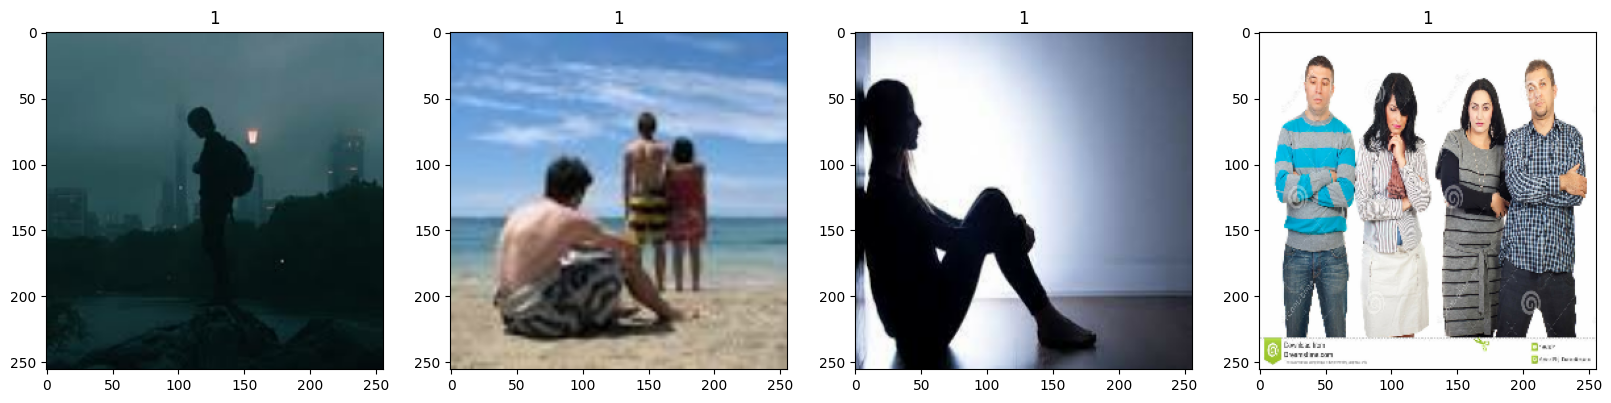

In [71]:
# Display sample images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [72]:
# Normalize pixel values to the range [0, 1]
data = data.map(lambda x,y: (x/255, y))

# Check normalization
data.as_numpy_iterator().next()

(array([[[[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          ...,
          [0.04705882, 0.05490196, 0.10588235],
          [0.04820652, 0.05604966, 0.10703006],
          [0.03888358, 0.04672672, 0.09770712]],
 
         [[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.03921569, 0.03137255, 0.07450981],
          ...,
          [0.04957108, 0.05741422, 0.11623774],
          [0.04545575, 0.05329889, 0.11212242],
          [0.04143689, 0.04928003, 0.10810355]],
 
         [[0.04313726, 0.03529412, 0.07843138],
          [0.04313726, 0.03529412, 0.07843138],
          [0.03921569, 0.03137255, 0.07450981],
          ...,
          [0.05098039, 0.05882353, 0.11764706],
          [0.06239181, 0.07023495, 0.12905848],
          [0.0640686 , 0.07191174, 0.13073526]],
 
         ...,
 
         [[0.03137255, 0.02352941, 0.06666667],
          [0.03137

# 5. Split Data

In [73]:
# Split data into training, validation, and testing sets
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [74]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [75]:
# Import model building blocks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Create a sequential model
model = Sequential()

# Add the first convolutional layer with ReLU activation
# - 16 filters of size 3x3 applied to the input image with 3 channels (RGB)
# - ReLU activation function for non-linearity
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# Add a MaxPooling layer for downsampling
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten the output of the convolutional layers into a 1D vector
model.add(Flatten())

# Add a fully connected layer with ReLU activation
# - 256 neurons for feature extraction
model.add(Dense(256, activation='relu'))

# Add the output layer with sigmoid activation for binary classification (happy vs sad)
model.add(Dense(1, activation='sigmoid'))

# Compile the model using Adam optimizer, binary crossentropy loss, and accuracy metric
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [76]:
# Define a directory for TensorBoard logs (optional for visualization)
logdir='logs'

# Create a TensorBoard callback to track training progress
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Train the model on the training data for 20 epochs
# Validate the model's performance on the validation data during training
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4583 - loss: 1.1809

W0000 00:00:1711383883.113559     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.4690 - loss: 1.1531 - val_accuracy: 0.7500 - val_loss: 0.6653
Epoch 2/20


W0000 00:00:1711383886.187032     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.5776 - loss: 0.6732 - val_accuracy: 0.5625 - val_loss: 0.6378
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 391ms/step - accuracy: 0.5850 - loss: 0.6456 - val_accuracy: 0.5938 - val_loss: 0.5901
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step - accuracy: 0.5758 - loss: 0.6306 - val_accuracy: 0.6875 - val_loss: 0.5414
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.7893 - loss: 0.5103 - val_accuracy: 0.8750 - val_loss: 0.4222
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.8412 - loss: 0.3933 - val_accuracy: 0.8750 - val_loss: 0.4125
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - accuracy: 0.8859 - loss: 0.3585 - val_accuracy: 0.9531 - val_loss: 0.3120
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.9035 - loss: 0.3155 - val_accuracy: 0.9219 - val_loss: 0.2598
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.9513 - loss: 0.2087 - val_accuracy: 0.9844 - val_loss: 0.1293
Epo

# 8. Plot Performance

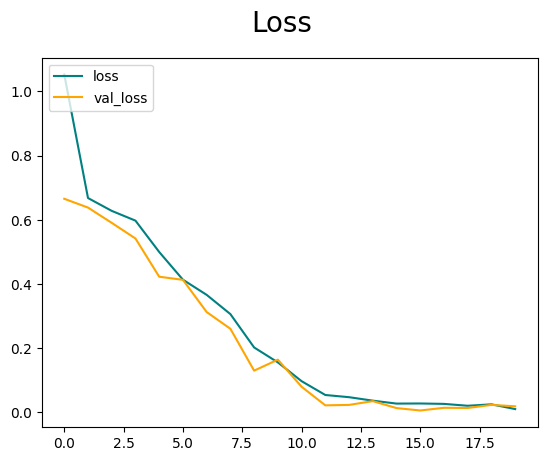

In [77]:
# Create separate figures for loss and accuracy
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

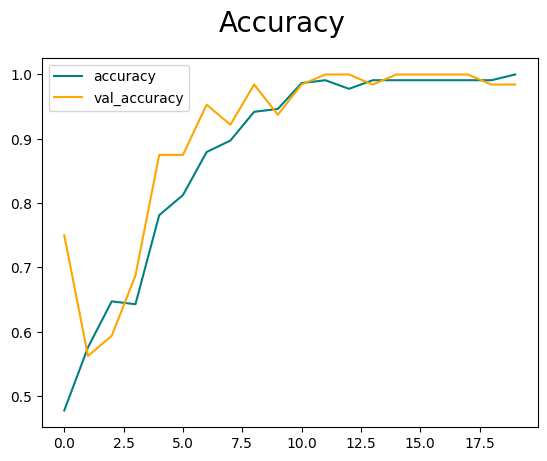

In [78]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [79]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Initialize metrics for precision, recall, and binary accuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# Loop through the test data in batches
for batch in test.as_numpy_iterator(): 
    # Separate features (X) and labels (y) from the batch
    X, y = batch
    # Make predictions on the test data
    yhat = model.predict(X)
    #Update the metrics with the ground truth labels (y) and predictions (yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Print the calculated precision, recall, and binary accuracy scores
print(pre.result(), re.result(), acc.result())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test the Model on a Single Image

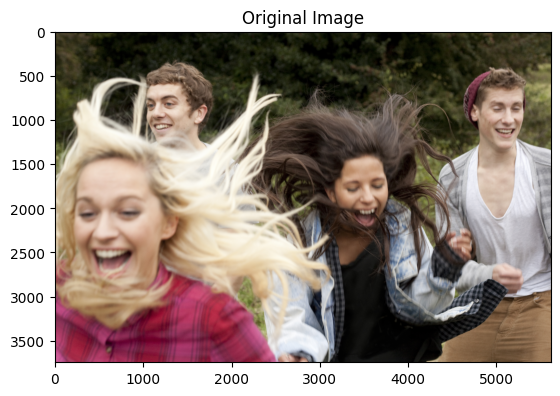

In [86]:
import cv2

# Load an image using OpenCV in BGR color format (OpenCV standard)
img = cv2.imread('/kaggle/input/happy-sad-image-data/154006829.jpg')

# Display the original image (converted to RGB for matplotlib)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

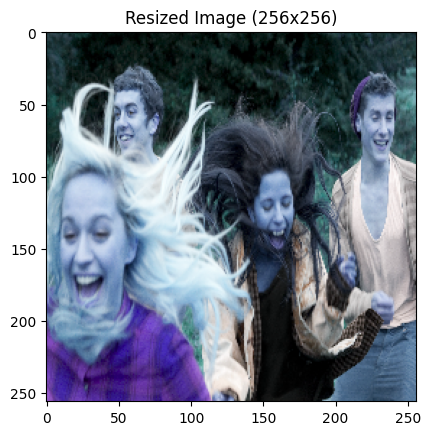

In [87]:
# Resize the image to match the model's input shape (256x256)
resize = tf.image.resize(img, (256,256))

# Display the resized image 
plt.imshow(resize.numpy().astype(int))
plt.title('Resized Image (256x256)')
plt.show()

In [90]:
# Make a prediction on the preprocessed image
yhat = model.predict(np.expand_dims(resize/255, 0))

array([[0.00148413]], dtype=float32)

In [89]:
# Interpret the prediction: happy (probability > 0.5) or sad (probability <= 0.5)
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [91]:
from tensorflow.keras.models import load_model

# Save the trained model for future use
model.save(os.path.join('models','happysadimageclassifier.h5'))

# Load the saved model (optional test)
new_model = load_model('/kaggle/working/models/happysadimageclassifier.h5')
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


In [92]:
# Interpret the prediction: happy (probability > 0.5) or sad (probability <= 0.5)
if yhat_new > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
